参考: https://qiita.com/sugulu_Ogawa_ISID/items/697bd03499c1de9cf082

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

print(torch.__version__)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

e:\anaconda_env\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0+cu113


device(type='cuda')

In [2]:
train_df = pd.read_csv("train_eval.tsv", sep="\t",  names=('text', 'label'))
test_df = pd.read_csv("test.tsv", sep="\t",  names=('text', 'label'))

test_df.head

<bound method NDFrame.head of                                                    text  label
0     Peachyでも大人気の「恋愛」をテーマにした記事の週間ランキングです！2012年6月21日...      5
1     値下げや利用可能国が拡大！テレコムスクエアは1日、ポストペイドタイプの海外向けSIMカード「...      6
2     ４月。新しい年度を迎え、新しい顧客の開拓、新しい取引先、新しい上司や同僚。エネルギーに満ち溢...      3
3     Xperia GXが発表！ソニーモバイルコミュニケーションズは9日、国内向けとして2012年...      6
4     1月も後半に入り、バレンタインデーの話題も増えてきた今日この頃。皆さんはチョコを贈る相手、決...      5
...                                                 ...    ...
1470  今週末26日、さいたまスーパーアリーナで開催される世界最高峰の総合格闘技イベント＝UFC日本...      7
1471  名番組「突撃！隣の晩ごはん」のヨネスケが、今度は「OLの昼ごはん」をレポートする。華やかな企...      0
1472  新年度を迎え、周りの環境も変わると、職場や取引先でも新しい出会いが増えるこの季節。名刺交換中...      5
1473  5日深夜、アルガルベカップで、宿敵アメリカ代表からはじめて勝利を挙げたサッカー女子日本代表＝...      7
1474  「男子厨房に入らず」—。「弁当男子」なんて言葉も登場している現代では、死語と言えるだろう。で...      0

[1475 rows x 2 columns]>

In [3]:
# データのカウント
label_list = train_df["label"].unique()
train_df["label"].value_counts() + test_df["label"].value_counts()


0    871
1    871
2    865
3    512
4    871
5    843
6    871
7    901
8    771
Name: label, dtype: int64

In [4]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=False)

In [5]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
from transformers import ElectraTokenizer, ElectraForSequenceClassification, BertJapaneseTokenizer, BertForSequenceClassification
# model_path = "cl-tohoku/bert-base-japanese"
model_path = "izumi-lab/electra-base-japanese-discriminator"
# model_path = "izumi-lab/electra-small-japanese-fin-discriminator"


In [7]:
tokenizer = BertJapaneseTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=len(label_list))

# freeze layers except last layer
for param in model.parameters():
    param.requires_grad = False

last_layer = list(model.children())[-1]
print(f'except last layer: {last_layer}')
for param in last_layer.parameters():
    param.requires_grad = True

Some weights of the model checkpoint at izumi-lab/electra-base-japanese-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at izumi-lab/electra-base-japanese-discriminator and are newly ini

except last layer: ElectraClassificationHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Linear(in_features=768, out_features=9, bias=True)
)
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [8]:
max_len = 100
train_encoding = tokenizer(train_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)
valid_encoding = tokenizer(valid_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)
test_encoding = tokenizer(test_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)

In [9]:
train_label = torch.tensor(train_df["label"].to_list())
valid_label = torch.tensor(valid_df["label"].to_list())
test_label = torch.tensor(test_df["label"].to_list())

In [10]:
# 0 番目 の 5 トーク ン までの ID を 表示
print(train_encoding["input_ids"][ 0][: 5]) 
# 0 番目 の 5 トーク ン までの トー クン を デコード し て 表示
print(tokenizer.decode(train_encoding["input_ids"][0][:5]))

tensor([    1, 28677,  4333, 12094,  4963])
[CLS] 転職 者 なら 誰


In [11]:
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__( self, idx):
        item = {key:torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item
    
    def __len__( self):
        return len(self.labels)

train_dataset = CreateDataset(train_encoding, train_label)
val_dataset = CreateDataset(valid_encoding, valid_label)
test_dataset = CreateDataset(test_encoding, test_label)


In [12]:
def saveModel(): 
    path = "./IzumiElectraModel_forbertseqclassifier_freeezparam.pth" 
    torch.save(model.state_dict(), path)

model = model.to(device)

In [18]:
loss_fn = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
validate_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True)

optimizer = AdamW(model.parameters(), lr=0.003)
model.train()
epochs = 50
train_losses = []
valid_losses = []
acc_epoc = []
best_accuracy = 0.0 

model.train()
#再学習
for epoch in range(epochs):
    running_train_loss = 0.0 
    running_accuracy = 0.0 
    running_vall_loss = 0.0 
    total = 0 

    # Training Loop 
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
        logits = outputs.logits
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        running_train_loss +=loss.item()

    # Calculate training loss value 
    train_loss_value = running_train_loss/len(train_loader) 
    train_losses.append(train_loss_value)
    
    # Validation Loop 
    with torch.no_grad(): 
        model.eval() 
        for batch in tqdm(validate_loader): 
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
            logits = outputs.logits
            val_loss = outputs.loss
            
            
            # The label with the highest value will be our prediction 
            _, predicted = torch.max(logits, 1) 
            running_vall_loss += val_loss.item()  
            total += logits.size(0) 
            running_accuracy += (predicted == labels).sum().item()

    # Calculate validation loss value 
    val_loss_value = running_vall_loss/len(validate_loader)
    valid_losses.append(val_loss_value)
            
    # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
    accuracy = (100 * running_accuracy / total)
    acc_epoc.append(accuracy)    

    # Save the model if the accuracy is the best 
    if accuracy > best_accuracy: 
        saveModel() 
        best_accuracy = accuracy

    print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %d %%' % (accuracy))

e:\anaconda_env\nlp\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/295 [00:00<?, ?it/s]C:\Users\windo\AppData\Local\Temp\ipykernel_26848\1214768838.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
C:\Users\windo\AppData\Local\Temp\ipykernel_26848\1214768838.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(se

Completed training batch 0 Training Loss is: 1.3404 Validation Loss is: 1.0874 Accuracy is 59 %


100%|██████████| 74/74 [00:06<00:00, 11.15it/s]


Completed training batch 1 Training Loss is: 0.7730 Validation Loss is: 1.0493 Accuracy is 65 %


100%|██████████| 74/74 [00:06<00:00, 11.12it/s]


Completed training batch 2 Training Loss is: 0.7592 Validation Loss is: 0.8911 Accuracy is 67 %


100%|██████████| 74/74 [00:06<00:00, 10.58it/s]


Completed training batch 3 Training Loss is: 0.7251 Validation Loss is: 0.8738 Accuracy is 68 %


100%|██████████| 74/74 [00:08<00:00,  8.31it/s]


Completed training batch 4 Training Loss is: 0.7211 Validation Loss is: 0.8390 Accuracy is 72 %


100%|██████████| 74/74 [00:08<00:00,  8.25it/s]


Completed training batch 5 Training Loss is: 0.7217 Validation Loss is: 0.9186 Accuracy is 68 %


100%|██████████| 74/74 [00:09<00:00,  8.16it/s]


Completed training batch 6 Training Loss is: 0.7190 Validation Loss is: 0.9347 Accuracy is 67 %


100%|██████████| 74/74 [00:09<00:00,  8.16it/s]


Completed training batch 7 Training Loss is: 0.7184 Validation Loss is: 0.8782 Accuracy is 69 %


100%|██████████| 74/74 [00:09<00:00,  8.15it/s]


Completed training batch 8 Training Loss is: 0.6912 Validation Loss is: 0.9195 Accuracy is 67 %


100%|██████████| 74/74 [00:08<00:00,  8.27it/s]


Completed training batch 9 Training Loss is: 0.6805 Validation Loss is: 0.8344 Accuracy is 71 %


100%|██████████| 74/74 [00:09<00:00,  8.12it/s]


Completed training batch 10 Training Loss is: 0.6664 Validation Loss is: 0.9923 Accuracy is 67 %


100%|██████████| 74/74 [00:09<00:00,  8.03it/s]


Completed training batch 11 Training Loss is: 0.6739 Validation Loss is: 0.8420 Accuracy is 71 %


100%|██████████| 74/74 [00:09<00:00,  8.02it/s]


Completed training batch 12 Training Loss is: 0.6604 Validation Loss is: 0.8780 Accuracy is 70 %


100%|██████████| 74/74 [00:09<00:00,  7.97it/s]


Completed training batch 13 Training Loss is: 0.6594 Validation Loss is: 0.8145 Accuracy is 71 %


100%|██████████| 74/74 [00:09<00:00,  7.99it/s]


Completed training batch 14 Training Loss is: 0.6392 Validation Loss is: 0.8648 Accuracy is 70 %


100%|██████████| 74/74 [00:09<00:00,  7.97it/s]


Completed training batch 15 Training Loss is: 0.6426 Validation Loss is: 0.9428 Accuracy is 68 %


100%|██████████| 74/74 [00:09<00:00,  7.97it/s]


Completed training batch 16 Training Loss is: 0.6296 Validation Loss is: 0.8751 Accuracy is 70 %


100%|██████████| 74/74 [00:09<00:00,  7.95it/s]


Completed training batch 17 Training Loss is: 0.6211 Validation Loss is: 0.8668 Accuracy is 70 %


100%|██████████| 74/74 [00:09<00:00,  7.92it/s]


Completed training batch 18 Training Loss is: 0.6383 Validation Loss is: 0.9211 Accuracy is 70 %


100%|██████████| 74/74 [00:09<00:00,  7.93it/s]


Completed training batch 19 Training Loss is: 0.6135 Validation Loss is: 0.8614 Accuracy is 72 %


100%|██████████| 74/74 [00:09<00:00,  7.93it/s]


Completed training batch 20 Training Loss is: 0.6089 Validation Loss is: 0.9160 Accuracy is 69 %


100%|██████████| 74/74 [00:09<00:00,  7.90it/s]


Completed training batch 21 Training Loss is: 0.5966 Validation Loss is: 0.8350 Accuracy is 71 %


100%|██████████| 74/74 [00:09<00:00,  7.90it/s]


Completed training batch 22 Training Loss is: 0.6019 Validation Loss is: 0.9430 Accuracy is 69 %


100%|██████████| 74/74 [00:09<00:00,  7.89it/s]


Completed training batch 23 Training Loss is: 0.6125 Validation Loss is: 0.9315 Accuracy is 69 %


100%|██████████| 74/74 [00:09<00:00,  7.90it/s]


Completed training batch 24 Training Loss is: 0.5880 Validation Loss is: 0.8296 Accuracy is 71 %


100%|██████████| 74/74 [00:09<00:00,  7.88it/s]


Completed training batch 25 Training Loss is: 0.5636 Validation Loss is: 0.8152 Accuracy is 73 %


100%|██████████| 74/74 [00:09<00:00,  7.93it/s]


Completed training batch 26 Training Loss is: 0.5737 Validation Loss is: 0.9466 Accuracy is 69 %


100%|██████████| 74/74 [00:09<00:00,  7.89it/s]


Completed training batch 27 Training Loss is: 0.5742 Validation Loss is: 0.9077 Accuracy is 71 %


100%|██████████| 74/74 [00:09<00:00,  7.89it/s]


Completed training batch 28 Training Loss is: 0.5728 Validation Loss is: 1.1102 Accuracy is 64 %


100%|██████████| 74/74 [00:09<00:00,  7.88it/s]


Completed training batch 29 Training Loss is: 0.5932 Validation Loss is: 0.9111 Accuracy is 71 %


100%|██████████| 74/74 [00:09<00:00,  7.92it/s]


Completed training batch 30 Training Loss is: 0.5485 Validation Loss is: 0.9657 Accuracy is 68 %


100%|██████████| 74/74 [00:09<00:00,  7.94it/s]


Completed training batch 31 Training Loss is: 0.5513 Validation Loss is: 0.8846 Accuracy is 70 %


100%|██████████| 74/74 [00:09<00:00,  8.08it/s]


Completed training batch 32 Training Loss is: 0.5354 Validation Loss is: 1.1487 Accuracy is 66 %


100%|██████████| 74/74 [00:09<00:00,  7.82it/s]


Completed training batch 33 Training Loss is: 0.5596 Validation Loss is: 0.8818 Accuracy is 71 %


100%|██████████| 74/74 [00:09<00:00,  7.92it/s]


Completed training batch 34 Training Loss is: 0.5578 Validation Loss is: 0.9222 Accuracy is 69 %


100%|██████████| 74/74 [00:09<00:00,  7.83it/s]


Completed training batch 35 Training Loss is: 0.5577 Validation Loss is: 0.9195 Accuracy is 70 %


100%|██████████| 74/74 [00:09<00:00,  8.01it/s]


Completed training batch 36 Training Loss is: 0.5476 Validation Loss is: 0.8831 Accuracy is 71 %


100%|██████████| 74/74 [00:09<00:00,  7.78it/s]


Completed training batch 37 Training Loss is: 0.5269 Validation Loss is: 0.8610 Accuracy is 71 %


100%|██████████| 74/74 [00:09<00:00,  7.93it/s]


Completed training batch 38 Training Loss is: 0.5246 Validation Loss is: 0.9148 Accuracy is 70 %


100%|██████████| 74/74 [00:09<00:00,  7.88it/s]


Completed training batch 39 Training Loss is: 0.5241 Validation Loss is: 0.8961 Accuracy is 71 %


100%|██████████| 74/74 [00:09<00:00,  7.81it/s]


Completed training batch 40 Training Loss is: 0.5092 Validation Loss is: 0.8709 Accuracy is 72 %


100%|██████████| 74/74 [00:09<00:00,  7.85it/s]


Completed training batch 41 Training Loss is: 0.5442 Validation Loss is: 0.8730 Accuracy is 72 %


100%|██████████| 74/74 [00:09<00:00,  7.87it/s]


Completed training batch 42 Training Loss is: 0.5380 Validation Loss is: 0.9677 Accuracy is 71 %


100%|██████████| 74/74 [00:09<00:00,  7.87it/s]


Completed training batch 43 Training Loss is: 0.5177 Validation Loss is: 0.8358 Accuracy is 72 %


100%|██████████| 74/74 [00:09<00:00,  7.90it/s]


Completed training batch 44 Training Loss is: 0.4905 Validation Loss is: 0.9775 Accuracy is 68 %


100%|██████████| 74/74 [00:09<00:00,  7.88it/s]


Completed training batch 45 Training Loss is: 0.5002 Validation Loss is: 0.8235 Accuracy is 73 %


100%|██████████| 74/74 [00:09<00:00,  7.90it/s]


Completed training batch 46 Training Loss is: 0.4826 Validation Loss is: 0.8749 Accuracy is 72 %


100%|██████████| 74/74 [00:09<00:00,  7.84it/s]


Completed training batch 47 Training Loss is: 0.4877 Validation Loss is: 0.8770 Accuracy is 72 %


100%|██████████| 74/74 [00:09<00:00,  7.89it/s]


Completed training batch 48 Training Loss is: 0.4887 Validation Loss is: 0.9581 Accuracy is 71 %


100%|██████████| 74/74 [00:09<00:00,  7.85it/s]

Completed training batch 49 Training Loss is: 0.4711 Validation Loss is: 0.9338 Accuracy is 70 %


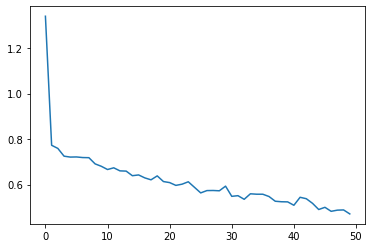

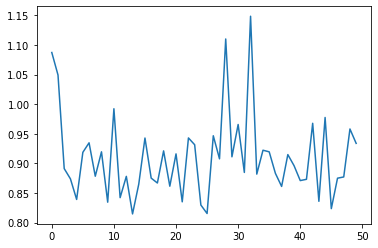

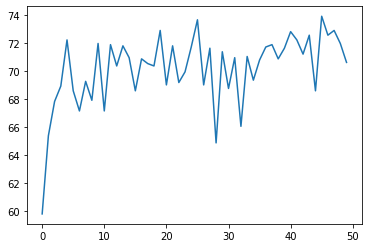

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
losses_ = [loss for loss in train_losses]
plt.plot(losses_)
plt.show()

losses_ = [loss for loss in valid_losses]
plt.plot(losses_)
plt.show()

losses_ = [loss for loss in acc_epoc]
plt.plot(losses_)
plt.show()


In [21]:
model.load_state_dict(torch.load('./model/IzumiElectraModel_forbertseqclassifier_freeezparam.pth'))
model.eval()
preds = []
test_label = test_df["label"].to_list()
with torch.no_grad():
    for words in tqdm(test_df["text"].to_list()):
        text = "".join(words)
        inputs = tokenizer.encode(text, return_tensors="pt",padding=True, truncation=True, max_length=max_len).to(device)
        outputs = model(inputs)
        logits = outputs.logits
        pred=logits.argmax(1).item()
        preds.append(pred)

100%|██████████| 1475/1475 [00:24<00:00, 59.21it/s]


In [22]:
correct_cnt = 0
for pred, ans in zip(preds, test_label):
    if pred == ans:
        correct_cnt += 1
print( correct_cnt/ len(test_label))

0.7457627118644068


カテゴリー数: 9
['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']


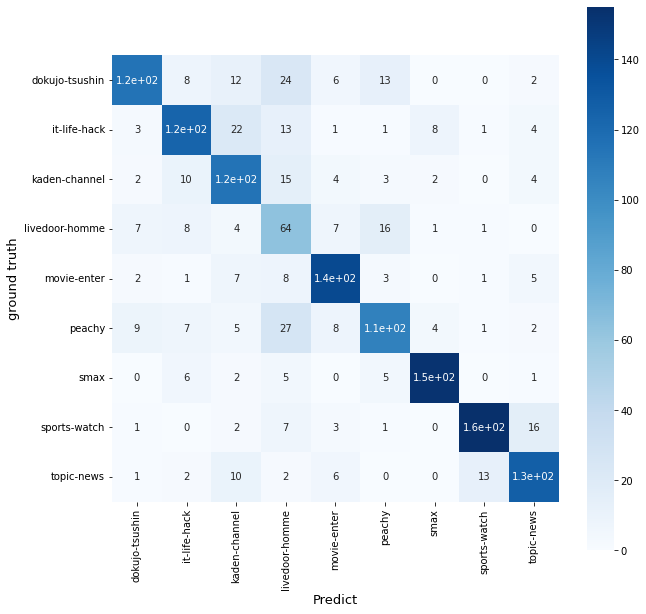

In [25]:
from sklearn.metrics import confusion_matrix
import os
categories = [name for name in os.listdir(
    "./data/livedoor/text/") if os.path.isdir("./data/livedoor/text/"+name)]

print("カテゴリー数:", len(categories))
print(categories)

cm = confusion_matrix(test_label, preds)
cm = pd.DataFrame(data=cm, index=categories, 
                           columns=categories,)

fig = plt.figure()
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel("Predict", fontsize=13, rotation=0)
plt.ylabel("ground truth", fontsize=13)
fig.set_figheight(10)
fig.set_figwidth(10)